###pip and import


In [0]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import time
from tqdm import tqdm
import itertools
import codecs
import re
import numpy as np
from sklearn.model_selection import train_test_split

%tensorflow_version 1.x
import tensorflow as tf

In [4]:
import tf.keras.callbacks
from tf.keras.utils.data_utils import Sequence
from tf.keras.optimizers import Adam
from tf.keras import backend as K
from tf.keras.models import Model

tf.enable_control_flow_v2()

ModuleNotFoundError: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


###Download and decode data for OCR

In [0]:
!gsutil ls gs://energy_meters_dataset/

gs://energy_meters_dataset/BLUR_DATASETV6.zip
gs://energy_meters_dataset/ENERGY_METERS_009_SEGM_ANNOTATIONS.zip
gs://energy_meters_dataset/ENERGY_METERS_009_SEGM_IMAGES_AND_MASKS.zip
gs://energy_meters_dataset/ENERGY_METERS_010_SEGM_IMAGES_ANN_MASKS.zip
gs://energy_meters_dataset/KOROSTELEV_ANNOTATIONS_07_12_19-20191207T074808Z-001.zip
gs://energy_meters_dataset/NewDataset_energy_meters.zip
gs://energy_meters_dataset/dataset_amhtj_new.zip
gs://energy_meters_dataset/dataset_for_dcgan_energy_meter_field.zip
gs://energy_meters_dataset/dataset_for_dcgan_energy_meter_field_annotations.csv
gs://energy_meters_dataset/dataset_quality_2757_defocused_blured_RandGor.zip
gs://energy_meters_dataset/dataset_quality_randgor.zip
gs://energy_meters_dataset/dataset_v_08_19_11_19_with_annotations.zip
gs://energy_meters_dataset/new_dataset_energy_meters_rf0_7.zip
gs://energy_meters_dataset/via_region_data.csv
gs://energy_meters_dataset/via_region_data.json
gs://energy_meters_dataset/Downloads/
gs://energy

In [0]:
!gsutil cp -r gs://energy_meters_dataset/NewDataset_energy_meters.zip ./

Copying gs://energy_meters_dataset/NewDataset_energy_meters.zip...
- [1 files][ 1004 MiB/ 1004 MiB]   54.3 MiB/s                                   
Operation completed over 1 objects/1004.1 MiB.                                   


In [0]:
!unzip -qq NewDataset_energy_meters.zip

NewDataset_energy_meters/barcode/DSC_лічильник-1-1024x685.jpg/:  mismatching "local" filename (NewDataset_energy_meters/barcode/DSC_╨╗╤Ц╤З╨╕╨╗╤М╨╜╨╕╨║-1-1024x685.jpg/),
         continuing with "central" filename version
NewDataset_energy_meters/barcode/DSC_лічильник-1-1024x685.jpg/1580187221_mmoiseev.json.jpg:  mismatching "local" filename (NewDataset_energy_meters/barcode/DSC_╨╗╤Ц╤З╨╕╨╗╤М╨╜╨╕╨║-1-1024x685.jpg/1580187221_mmoiseev.json.jpg),
         continuing with "central" filename version
NewDataset_energy_meters/barcode/DSC_лічильник-1-1024x685.jpg/1580189680_mmoiseev.json.jpg:  mismatching "local" filename (NewDataset_energy_meters/barcode/DSC_╨╗╤Ц╤З╨╕╨╗╤М╨╜╨╕╨║-1-1024x685.jpg/1580189680_mmoiseev.json.jpg),
         continuing with "central" filename version
NewDataset_energy_meters/data/annotations/segmentation/DSC_лічильник-1-1024x685.jpg/:  mismatching "local" filename (NewDataset_energy_meters/data/annotations/segmentation/DSC_╨╗╤Ц╤З╨╕╨╗╤М╨╜╨╕╨║-1-1024x685.jpg/),
         con

In [0]:
!rm /content/NewDataset_energy_meters.zip

In [0]:
DATA_DIR='/content/NewDataset_energy_meters'
SEG_DIR='/content/segmentations/'
READ_DIR='/content/read_area/'
SERIAL_DIR='/content/serial_area/'
SEG_SHAPE=None
READ_SHAPE=None
SERIAL_SHAPE=None
os.listdir(DATA_DIR)

['masks',
 'data',
 'serial_number_vertical',
 'barcode',
 'serial_number',
 'reading']

In [0]:
df = pd.read_csv(DATA_DIR+'/data/datasets/dataset_v12.csv')

In [0]:
df

,image,annotation
0,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
1,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
2,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
3,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
4,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
...,...,...
1674,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
1675,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
1676,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
1677,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...


In [0]:
def repath(x):
  return x.split('REGINA')[1]

def repath_df(df):
  return df.apply(repath)
  
df['image'] = repath_df(df['image'])
df['annotation'] = repath_df(df['annotation'])

In [0]:
def decode_annot(x):
  fname = DATA_DIR + x
  fdata = open(fname, 'r').read()
  jdata = json.loads(fdata)
  return jdata

def decode_df(df):
  return df.apply(decode_annot)
  
df['jdata'] = decode_df(df['annotation'])

In [0]:
def rect2poly(rect):
  all_x = []
  all_y = []
  all_x.append(rect['x'])
  all_y.append(rect['y'])
  all_x.append(rect['x'] + rect['width'])
  all_y.append(rect['y'])
  all_x.append(rect['x'] + rect['width'])
  all_y.append(rect['y'] + rect['height'])
  all_x.append(rect['x'])
  all_y.append(rect['y'] + rect['height'])
  return all_x, all_y

def decode_jdata(x):
  res_data = {
      'serial_x': None,
      'serial_y': None,
      'reader_x': None,
      'reader_y': None,
  }

  regions = x['jdata']['regions']
  for r in regions:
    if('mask_type' in r['region_attributes'] and 'value' in r['region_attributes']):
      if('polygon' in r['shape_attributes']['name']):      
        if('serial' in r['region_attributes']['mask_type']):
          x['value_s'] = r['region_attributes']['value']
          x['serial_x'] = r['shape_attributes']['all_points_x']
          x['serial_y'] = r['shape_attributes']['all_points_y']

        if('reading' in r['region_attributes']['mask_type']):
          x['value_r'] = r['region_attributes']['value']
          x['reader_x'] = r['shape_attributes']['all_points_x']
          x['reader_y'] = r['shape_attributes']['all_points_y']

      if('rect' in r['shape_attributes']['name']):
        if('serial' in r['region_attributes']['mask_type']):
          x['value_s'] = r['region_attributes']['value']
          x['serial_x'], x['serial_y'] = rect2poly(r['shape_attributes'])

        if('reader' in r['region_attributes']['mask_type']):
          x['value_r'] = r['region_attributes']['value']
          x['reader_x'], x['reader_y'] = rect2poly(r['shape_attributes'])
  return x

def decode_jdata_df(df):
  return df.apply(lambda x: decode_jdata(x), axis = 1)  

res = decode_jdata_df(df)
res = res[res['value_s'].notnull()]
res = res[res['value_r'].notnull()]
res['value_s'] = res['value_s'].map(lambda row: row.split("№")[-1])
res['value_s'] = res['value_s'].map(lambda row: row.replace("-", ""))
res['value_r'] = res['value_r'].map(lambda row: row.replace(".", ""))
res['value_r'] = res['value_r'].map(lambda row: row.replace(",", ""))
res['data_index'] = res['value_r'].index.to_list()

In [0]:
res

,annotation,image,jdata,reader_x,reader_y,serial_x,serial_y,value_r,value_s,data_index
0,/data/annotations/segmentation/good (338).jpg/...,/data/original_images/good (338).jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[175, 342, 341, 174]","[190, 187, 207, 209]","[320, 399, 400, 320]","[316, 313, 325, 328]",002229,211330,0
1,/data/annotations/segmentation/1655.jpg/157975...,/data/original_images/1655.jpg,"{'filename': '1655.jpg', 'size': 100682, 'regi...","[179, 348, 349, 180]","[234, 232, 261, 262]","[289, 389, 389, 289]","[427, 427, 444, 444]",000011,08478375,1
2,/data/annotations/segmentation/box_268_020.jpg...,/data/original_images/box_268_020.jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[169, 1004, 995, 161]","[400, 430, 595, 572]","[672, 1206, 1206, 672]","[807, 811, 872, 869]",0000797,305224,2
3,/data/annotations/segmentation/1450802582_Schi...,/data/original_images/1450802582_Schietchik-el...,"{'size': -1, 'regions': [{'shape_attributes': ...","[133, 133, 444, 447]","[141, 199, 199, 136]","[65, 67, 230, 229]","[372, 400, 394, 370]",00000298,60871420,3
4,/data/annotations/segmentation/IMG_20191117_15...,/data/original_images/IMG_20191117_152218.jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[1690, 2521, 2537, 1691]","[1965, 1947, 2110, 2120]","[2759, 3237, 3237, 2761]","[2091, 2093, 2153, 2147]",563184,0524568809,4
...,...,...,...,...,...,...,...,...,...,...
1674,/data/annotations/segmentation/1546.jpg/157975...,/data/original_images/1546.jpg,"{'filename': '1546.jpg', 'size': 1645543, 'reg...","[189, 193, 1059, 1055]","[720, 848, 808, 667]","[445, 444, 737, 737]","[1120, 1174, 1161, 1110]",000024,39728598,1674
1675,/data/annotations/segmentation/1604.jpg/157975...,/data/original_images/1604.jpg,"{'filename': '1604.jpg', 'size': 35848, 'regio...","[26, 22, 188, 187]","[152, 179, 186, 160]","[72, 72, 130, 130]","[225, 235, 236, 226]",000024,36478200,1675
1676,/data/annotations/segmentation/good (203).jpg/...,/data/original_images/good (203).jpg,"{'filename': 'good (203).jpg', 'size': 64708, ...","[89, 209, 209, 88]","[237, 238, 279, 276]","[123, 238, 239, 124]","[374, 374, 388, 387]",37551,0854390,1676
1677,/data/annotations/segmentation/good (181).jpg/...,/data/original_images/good (181).jpg,"{'filename': 'good (181).jpg', 'size': 335319,...","[187, 735, 735, 186]","[287, 308, 399, 387]","[739, 975, 975, 740]","[605, 607, 632, 630]",002914,011067091180652,1677


In [0]:
def get_mask(im, x):
  mask = np.zeros(im.shape)
  pts = np.array((x['reader_x'], x['reader_y']))
  pts = np.moveaxis(pts, 0, -1)
  cv2.fillPoly(mask, np.int32([pts]), (1, 0, 0))
  
  pts = np.array((x['serial_x'], x['serial_y']))
  pts = np.moveaxis(pts, 0, -1)
  cv2.fillPoly(mask, np.int32([pts]), (0, 1, 0))
  return mask

def get_crop_by_mask(im, mask, ch = 0):
  cnt, _ = cv2.findContours(mask[:, :, ch].astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  rect = cv2.boundingRect(cnt[0])
  return im[int(rect[1]):int(rect[1]) + int(rect[3]), int(rect[0]):int(rect[0]) + int(rect[2]), :].copy()

In [0]:
!rm -rf {SEG_DIR}
!rm -rf {READ_DIR}
!rm -rf {SERIAL_DIR}
!mkdir {SEG_DIR}
!mkdir {READ_DIR}
!mkdir {SERIAL_DIR}
train_df = []

for i in tqdm(range(len(res))):
  d = res.iloc[i]
  im = cv2.imread(DATA_DIR + d['image'])

  d['height'] = im.shape[0]
  d['width'] = im.shape[1]
  mask = get_mask(im, d)

  crop_r = get_crop_by_mask(im, mask, ch = 0)
  crop_s = get_crop_by_mask(im, mask, ch = 1)

  ind = d['data_index']
  seg_name = f'{ind}.png'
  serial_name = f'{ind}.png'
  read_name = f'{ind}.png'
  d['is_serial_vertical'] = crop_s.shape[0] > crop_s.shape[1]
  if(SEG_SHAPE):
    mask = cv2.resize(mask, SEG_SHAPE)

  if(READ_SHAPE):
    crop_r = cv2.resize(crop_r, READ_SHAPE)

  if(SERIAL_SHAPE):
    crop_s = cv2.resize(crop_s, SERIAL_SHAPE)

  cv2.imwrite(SEG_DIR + seg_name, mask)
  cv2.imwrite(READ_DIR + read_name, crop_r)
  cv2.imwrite(SERIAL_DIR + serial_name, crop_s)
  
  train_df.append(d)

train_df = pd.DataFrame(train_df)

  0%|          | 0/1358 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/l

In [0]:
train_df.to_csv('train_df.csv', index = False)

In [0]:
train_df=pd.read_csv('train_df.csv')

In [0]:
train_df.head()

,annotation,image,jdata,reader_x,reader_y,serial_x,serial_y,value_r,value_s,data_index,height,width,is_serial_vertical
0,/data/annotations/segmentation/good (338).jpg/...,/data/original_images/good (338).jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[175, 342, 341, 174]","[190, 187, 207, 209]","[320, 399, 400, 320]","[316, 313, 325, 328]",002229,211330,0,600,800,False
1,/data/annotations/segmentation/1655.jpg/157975...,/data/original_images/1655.jpg,"{'filename': '1655.jpg', 'size': 100682, 'regi...","[179, 348, 349, 180]","[234, 232, 261, 262]","[289, 389, 389, 289]","[427, 427, 444, 444]",000011,08478375,1,766,564,False
2,/data/annotations/segmentation/box_268_020.jpg...,/data/original_images/box_268_020.jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[169, 1004, 995, 161]","[400, 430, 595, 572]","[672, 1206, 1206, 672]","[807, 811, 872, 869]",0000797,305224,2,1229,1373,False
3,/data/annotations/segmentation/1450802582_Schi...,/data/original_images/1450802582_Schietchik-el...,"{'size': -1, 'regions': [{'shape_attributes': ...","[133, 133, 444, 447]","[141, 199, 199, 136]","[65, 67, 230, 229]","[372, 400, 394, 370]",00000298,60871420,3,441,640,False
4,/data/annotations/segmentation/IMG_20191117_15...,/data/original_images/IMG_20191117_152218.jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[1690, 2521, 2537, 1691]","[1965, 1947, 2110, 2120]","[2759, 3237, 3237, 2761]","[2091, 2093, 2153, 2147]",563184,0524568809,4,3120,4160,False


###Исследуем


In [0]:
from ast import literal_eval

min_width_r = 100000.
min_width_s = 100000.
min_height_r = 100000.
min_height_s = 100000.

for index, row in train_df.iterrows():
    xr = (sorted(literal_eval(row['reader_x']))[3] - sorted(literal_eval(row['reader_x']))[0] + 1) / int(row['width'])
    if(min_width_r > xr): 
        min_width_r = xr
    
    xs = (sorted(literal_eval(row['serial_x']))[3] - sorted(literal_eval(row['serial_x']))[0] + 1) / int(row['width'])
    if(min_width_s > xs): 
        min_width_s = xs

    yr = (sorted(literal_eval(row['reader_y']))[3] - sorted(literal_eval(row['reader_y']))[0] + 1) / int(row['height'])
    if(min_height_r > yr): 
        min_height_r = yr
    
    ys = (sorted(literal_eval(row['serial_y']))[3] - sorted(literal_eval(row['serial_y']))[0] + 1) / int(row['height'])
    if(min_height_s > ys): 
        min_height_s = ys


In [0]:
print(min_width_r, # минимальное отношение ширины показателей к ширине изображения
min_width_s, # минимальное отношение ширины серийников к ширине изображения
min_height_r, # минимальное отношение высоты показателей к высоте изображения
min_height_s) # минимальное отношение высоты серийников к высоте изображения

0.022222222222222223 0.0078125 0.008333333333333333 0.00390625


###Закончили исследовать

In [0]:
pretrain_df = train_df[train_df['is_serial_vertical'] == False]
pretrain_df = pretrain_df[pretrain_df['value_r'].str.contains('\(') == False]
pretrain_df = pretrain_df[pretrain_df['value_r'].str.contains('-') == False]
pretrain_df = pretrain_df[pretrain_df['value_r'].str.contains('_') == False]
pretrain_df = pretrain_df[pretrain_df['value_r'].str.contains(' ') == False]

In [0]:
pretrain_df

,annotation,image,jdata,reader_x,reader_y,serial_x,serial_y,value_r,value_s,data_index,height,width,is_serial_vertical
0,/data/annotations/segmentation/good (338).jpg/...,/data/original_images/good (338).jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[175, 342, 341, 174]","[190, 187, 207, 209]","[320, 399, 400, 320]","[316, 313, 325, 328]",002229,211330,0,600,800,False
1,/data/annotations/segmentation/1655.jpg/157975...,/data/original_images/1655.jpg,"{'filename': '1655.jpg', 'size': 100682, 'regi...","[179, 348, 349, 180]","[234, 232, 261, 262]","[289, 389, 389, 289]","[427, 427, 444, 444]",000011,08478375,1,766,564,False
2,/data/annotations/segmentation/box_268_020.jpg...,/data/original_images/box_268_020.jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[169, 1004, 995, 161]","[400, 430, 595, 572]","[672, 1206, 1206, 672]","[807, 811, 872, 869]",0000797,305224,2,1229,1373,False
3,/data/annotations/segmentation/1450802582_Schi...,/data/original_images/1450802582_Schietchik-el...,"{'size': -1, 'regions': [{'shape_attributes': ...","[133, 133, 444, 447]","[141, 199, 199, 136]","[65, 67, 230, 229]","[372, 400, 394, 370]",00000298,60871420,3,441,640,False
4,/data/annotations/segmentation/IMG_20191117_15...,/data/original_images/IMG_20191117_152218.jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[1690, 2521, 2537, 1691]","[1965, 1947, 2110, 2120]","[2759, 3237, 3237, 2761]","[2091, 2093, 2153, 2147]",563184,0524568809,4,3120,4160,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,/data/annotations/segmentation/1546.jpg/157975...,/data/original_images/1546.jpg,"{'filename': '1546.jpg', 'size': 1645543, 'reg...","[189, 193, 1059, 1055]","[720, 848, 808, 667]","[445, 444, 737, 737]","[1120, 1174, 1161, 1110]",000024,39728598,1674,2286,2124,False
1354,/data/annotations/segmentation/1604.jpg/157975...,/data/original_images/1604.jpg,"{'filename': '1604.jpg', 'size': 35848, 'regio...","[26, 22, 188, 187]","[152, 179, 186, 160]","[72, 72, 130, 130]","[225, 235, 236, 226]",000024,36478200,1675,360,360,False
1355,/data/annotations/segmentation/good (203).jpg/...,/data/original_images/good (203).jpg,"{'filename': 'good (203).jpg', 'size': 64708, ...","[89, 209, 209, 88]","[237, 238, 279, 276]","[123, 238, 239, 124]","[374, 374, 388, 387]",37551,0854390,1676,480,360,False
1356,/data/annotations/segmentation/good (181).jpg/...,/data/original_images/good (181).jpg,"{'filename': 'good (181).jpg', 'size': 335319,...","[187, 735, 735, 186]","[287, 308, 399, 387]","[739, 975, 975, 740]","[605, 607, 632, 630]",002914,011067091180652,1677,976,1088,False


In [0]:
train_files, val_files = train_test_split(
    pretrain_df, test_size = 0.15, random_state = 2019
)

In [0]:
len(train_files)

997

In [0]:
letters_n = []
lres = pretrain_df['value_r'].astype(str).apply(list)
for l in lres:
  letters_n += l
letters_n = sorted(list(set(letters_n)))

In [0]:
letters_s = []
lres = pretrain_df['value_s'].astype(str).apply(list)
for l in lres:
  letters_s += l
letters_s = sorted(list(set(letters_s)))

In [0]:
def text_to_labels(text, is_serial = False):
  if(is_serial):
    return list(map(lambda x: letters_s.index(x), text))
    
  else:
    return list(map(lambda x: letters_n.index(x), text))

In [0]:
train_files

###Datagenerator

In [0]:
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, df, mode = 'fit',
                 base_path = '../input/recursion-cellular-image-classification/train',
                 batch_size = 32, shape = (64, 512), n_channels = 1, size = 9,
                 rotation_range = 0, fill_mode = 'nearest',
                 vertical_flip = False, horizontal_flip = False, rescale = 1/255.,
                 n_classes = 5, random_state = 2019, shuffle = True, len_seq = 32, len_line = 8, is_serial = False):
      

        self.is_serial = is_serial


        self.shape = shape
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.size = size
        self.base_path = base_path
        self.rotation_range = rotation_range
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale = rescale
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
        self.random_state = random_state
        
        self.len_seq = len_seq
        np.random.seed(self.random_state)
        self.on_epoch_end()

        if(is_serial):
          self.len_line = 16
        else:
          self.len_line = 8

        

    def __len__(self):
        'Denotes the number of batches per epoch'
        #print('len')
        return int((len(self.df) / self.batch_size))

    def __getitem__(self, index):

        batch_files = self.df.iloc[index * self.batch_size:(index+1) * self.batch_size]
        
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = self.__generate_y(batch_files)
            return [X, y, np.ones((self.batch_size, 1)) * self.len_seq, self.cur_data], np.zeros([self.batch_size,1])
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
        buf = np.empty((self.batch_size, self.shape[0], self.shape[1], 3))

        for i in range(len(batch_files)):

          if self.mode == 'fit':
            b = cv2.imread(READ_DIR+str(batch_files.iloc[i]['data_index']) + '.png')
          else:
            b = cv2.imread(batch_files[i])

          b = cv2.resize(b, (self.shape[1], self.shape[0]))
          buf[i, ] = b
          
        buf = buf * self.rescale
        return buf
    
    def __generate_y(self, batch_files):
        y = np.ones((self.batch_size, self.len_line)) * 100
        self.cur_data = np.zeros((self.batch_size, 1))

        for i in range(len(batch_files)):
          if(self.is_serial):
            data = batch_files.iloc[i]['value_s'].strip()

          else:
            data = batch_files.iloc[i]['value_r'].strip()
          
          self.cur_data[i] = len(data)
          
          y[i, :len(data)] = text_to_labels(data, self.is_serial)
          
        return y

In [0]:
gen = DataGeneratorFull(train_files, batch_size = 4, len_seq = 32, shape = (64, 512), is_serial = False)
val = DataGeneratorFull(val_files, batch_size = 4, len_seq = 32, shape = (64, 512), is_serial = False)

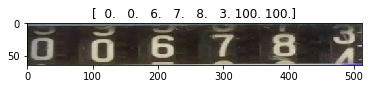

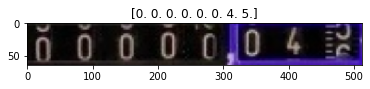

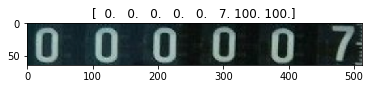

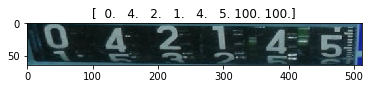

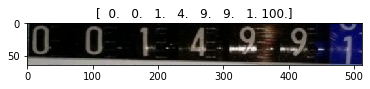

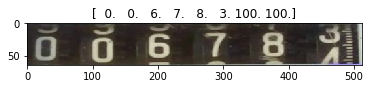

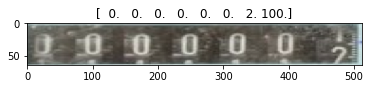

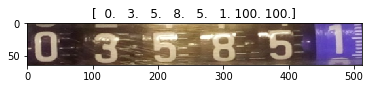

In [0]:
for i in range(0, 2):
    g = gen[i]
    d = g[0][0]
    l = g[0][1]
    b = g[0][2]
    c = g[0][3]
    for j in range(len(d)):       
        fig, axs = plt.subplots()
        plt.imshow(d[j])
        axs.set_title(str(l[j]))

###Build model

In [0]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, :, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [0]:
def buildLstmLayer(inputs, num_layers, num_units):
  """Build the lstm layer.

  Args:
    inputs: The input data.
    num_layers: How many LSTM layers do we want.
    num_units: The number of hidden units in the LSTM cell.
  """
  lstm_cells = []
  for i in range(num_layers):
      lstm_cells.append(tf.lite.experimental.nn.TFLiteLSTMCell(num_units))
  lstm_layers = tf.keras.layers.StackedRNNCells(lstm_cells)
  # Assume the input is sized as [batch, time, input_size], then we're going
  # to transpose to be time-majored.
  transposed_inputs = tf.transpose(inputs, perm=[1, 0, 2])
  
  outputs, _ = tf.lite.experimental.nn.dynamic_rnn( 
      lstm_layers,
      transposed_inputs,
      dtype='float32',
      time_major=True)
  # unstacked_outputs = tf.unstack(outputs, axis=0)
  return outputs

In [0]:
def build_model(input_shape = (64, 512, 3)):

    input_data = tf.keras.layers.Input(name = 'input_layer', shape = input_shape, dtype = 'float32')

    inner = tf.keras.layers.Conv2D(64, 1, padding = 'same', activation = 'relu', kernel_initializer='he_normal')(input_data)
    inner = tf.keras.layers.MaxPool2D()(inner)
    inner = tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer='he_normal')(inner)
    inner = tf.keras.layers.MaxPool2D()(inner)
    inner = tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer='he_normal')(inner)
    inner = tf.keras.layers.MaxPool2D()(inner)

    # backbone = keras.applications.mobilenet_v2.MobileNetV2(input_shape = input_shape, include_top = False, weights = 'imagenet', pooling = None)

    # backbone.summary()

    # inner = backbone(input_data)

    time_dense_size = 256
    rnn_size = 256
    num_lstm_layers = 2
    conv_to_rnn_dims = (32, 1024) #1280

    inner = tf.keras.layers.Reshape(target_shape = conv_to_rnn_dims, name = 'reshape')(inner)

    inner = tf.keras.layers.Dense(time_dense_size, activation = 'relu', name = 'dense1')(inner)

    #lstm_1_1 = keras.layers.GRU(256, activation = 'relu', return_sequences = True, name = 'lstm_1_1')(inner)
    #lstm_1b1 = keras.layers.GRU(256, activation = 'relu', return_sequences = True, name = 'lstm_1b1', go_backwards = True)(inner)

    #inner = keras.layers.add([lstm_1_1, lstm_1b1])

    inner = tf.keras.layers.BatchNormalization()(inner)
   
    with tf.variable_scope("rnn", reuse = tf.AUTO_REUSE):

        inner = buildLstmLayer(inner, num_lstm_layers, rnn_size)

        #lstm_2 = keras.layers.GRU(256, activation = 'relu', return_sequences = True, name = 'lstm2')(inner)
        #lstm_2b = keras.layers.GRU(256, activation = 'relu', return_sequences = True, name = 'lstm2b', go_backwards = True)(inner)

        inner = buildLstmLayer(inner, num_lstm_layers, rnn_size)

        inner = tf.keras.layers.Dense(11, activation = 'relu', kernel_initializer = 'he_normal', name = 'dense2')(inner)

        y_pred = tf.keras.layers.Activation('softmax', name = 'softmax')(inner)
        tf.keras.models.Model(inputs = input_data, outputs = y_pred).summary()

        labels = tf.keras.layers.Input(name = 'the_labels', shape = [8], dtype = 'float32')
        input_length = tf.keras.layers.Input(name = 'input_length', shape = [1], dtype = 'int64')
        label_length = tf.keras.layers.Input(name = 'label_length', shape = [1], dtype = 'int64')

        loss_out = tf.keras.layers.Lambda(ctc_lambda_func, output_shape = (1, ), name = 'ctc')([y_pred, labels, input_length, label_length])

        model = tf.keras.models.Model(inputs = [input_data, labels, input_length, label_length], outputs = y_pred)

        return model

In [0]:
tf.reset_default_graph()
ocr_model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 64, 512, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 512, 64)  256         input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 256, 64)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 256, 64)  36928       max_pooling2d[0][0]              
_____________

In [0]:
ocr_model.input_shape

[(None, 64, 512, 3), (None, 8), (None, 1), (None, 1)]

In [0]:
ocr_model.compile(loss = {'ctc': lambda y_true, y_pred: y_pred}, optimizer = tf.keras.optimizers.Adam(lr = 1e-2, decay = 1e-4))

In [0]:
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 3
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

In [0]:
check = keras.callbacks.ModelCheckpoint('mblnet_lstm_ocr.h5', monitor = 'val_loss', save_best_only = True)
#schedule = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose = 1) 

In [0]:
history = ocr_model.fit(
    gen,
    validation_data = val,
    workers = 4,
    epochs = 50,
    verbose = 1,
    shuffle = True,
    callbacks = [check],
    batch_size = 4 
)

ValueError: ignored

In [0]:
model=keras.models.Model(inputs=ocr_model.inputs[0],outputs=ocr_model.layers[-5].output)

###Predict


In [0]:
model.load_weights('/content/mobilenet_ocr.h5')

In [0]:
def mask_to_number(mask,trig=False):
  if(trig):
    size=len(mask)
  else:
    size=len(mask[0])
  res=[]
  for i in range(size):
    if(trig):
      res.append(np.argmax(mask[i]))
    else:
      res.append(np.argmax(mask[0,i]))
  return res

In [0]:
def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

In [0]:
def decode_predict_ctc(out, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
      beam_width = top_paths
    for i in range(top_paths):
      lables = keras.backend.get_value(keras.backend.ctc_decode(out, input_length=np.ones(out.shape[0])*out.shape[1],
                           greedy=False, beam_width=beam_width, top_paths=top_paths)[0][i])[0]
      text = labels_to_text(lables)
      results.append(text)
    return results

In [0]:
model.input_shape

(None, 64, 512, 3)

In [0]:
gdata=val.__getitem__(3)[0]
res=model.predict(gdata[0])

In [0]:
gdata[0].shape

(16, 64, 512, 3)

In [0]:
res.shape

(16, 128, 11)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
0 ['015', '018', '019']
1 ['010', '015', '018']
2 ['015', '010', '018']
3 ['105', '108', '109']


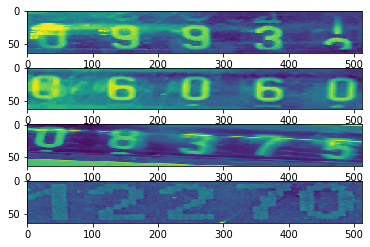

In [0]:
fig,axs=plt.subplots(4)
for i in range(4):
  axs[i].imshow(gdata[0][i,:,:,0])
  print(i,decode_predict_ctc(res[i:i+1],top_paths=3))